PRE n=600, mean = 3.85 min
POST n=650, mean = 4.84 min


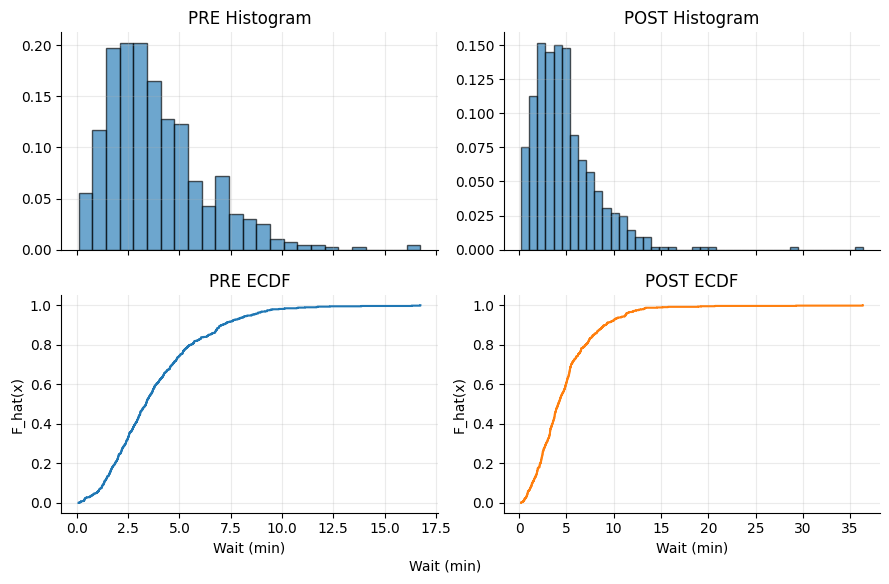

PRE outliers (15): [10.14030136 12.32986665 10.10332768  9.45031278  9.53380559 10.77904804
 10.72939333 11.69608819 16.74725379 13.87504804  9.85328962 11.73924492
 11.12046317  9.42228219 16.31647512]
POST outliers (22): [13.37106123 18.90672242 13.28706877 19.24747191 20.70682149 11.92570393
 12.39250722 13.23265007 12.8682883  12.32631409 13.1511014  15.17168217
 29.27458641 12.65177186 12.66722905 14.5597911  12.14088077 36.35593593
 15.73969792 13.25108244 12.07843156 12.05688732]
Candidate models: ['gamma', 'weibull_min', 'lognorm']
PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


PRE best model:  gamma  (AIC = 2600.90)
POST best model: lognorm (AIC = 3163.26)


,params,logL,k,AIC,ΔAIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927,0.0
lognorm,"(0.4535837982450181, -1.2934360536889793, 4.64...",-1298.316753,3,2602.633505,1.730578
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf,inf


,params,logL,k,AIC,ΔAIC
lognorm,"(0.5360203743986024, -1.0685227608888774, 5.12...",-1578.630755,3,3163.261511,0.0
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653,0.391489
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013,150.507502


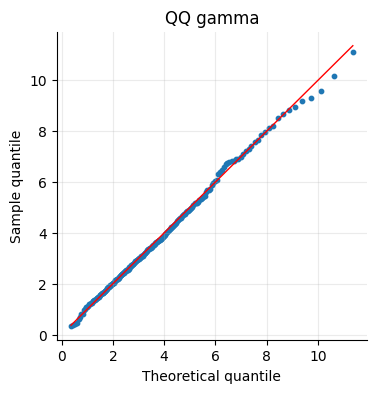

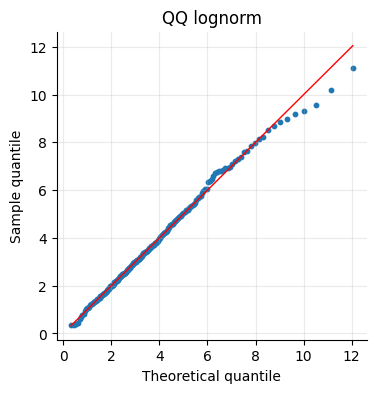

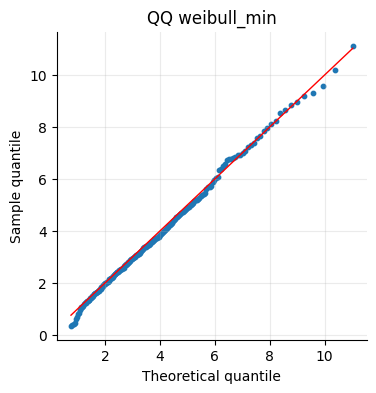

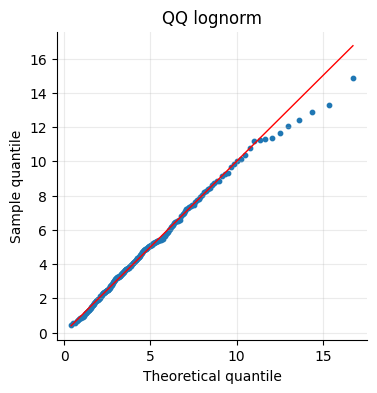

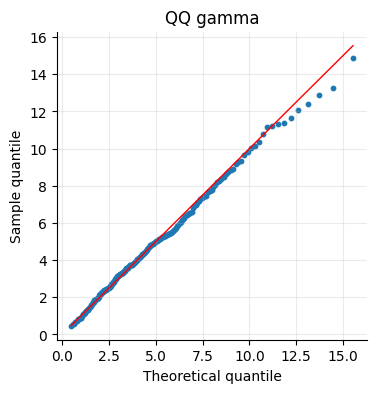

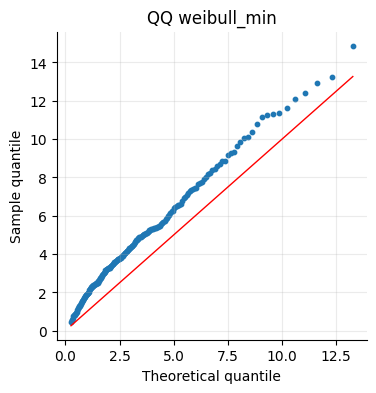

Best PRE model: gamma mean3.85 min
Best POST model: gamma mean4.84 min
Change POST-PRE: +0.99 min (1.26)


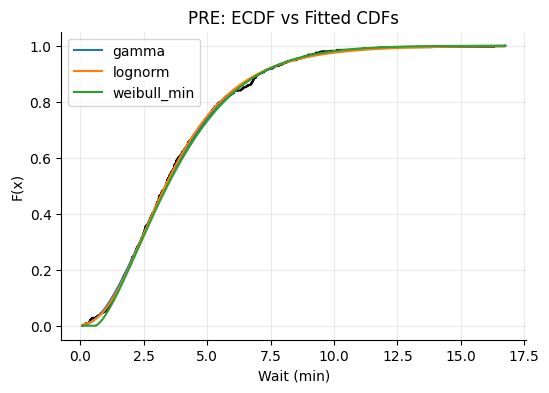

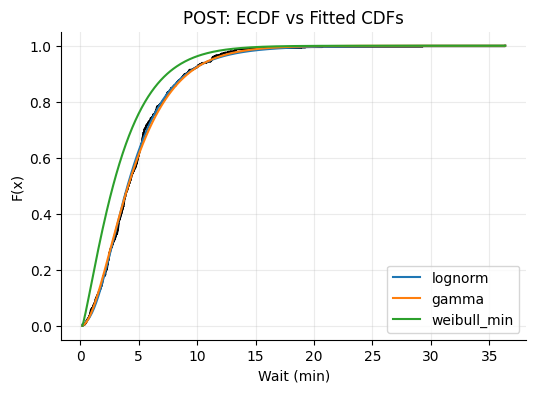

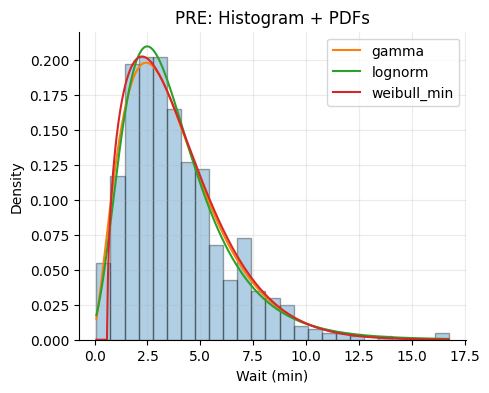

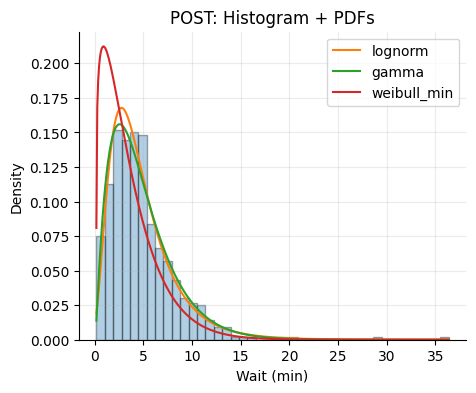

In [32]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha":0.25,
})

def plot_ecdf(data, ax=None,**kw):
    ec = ECDF(data)
    ax=ax or plt.gca()
    ax.step(ec.x,ec.y,where='post',**kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)")
    return ax

def aic(logL, k):
    return 2*k - 2*logL

def mean_from_params(dist_name, params):
    if dist_name == "gamma":
        a, loc, scale = params # a = shape (k)
        return loc + a*scale # Gamma mean = loc + k*theta
    elif dist_name == "weibull_min":
        c, loc, scale = params # c = shape
    # Weibull mean uses the gamma function:
        return loc + scale*st.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params # s = sigma (log-scale SD); scale = exp(mu)
        # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

#LOAD DATA
df = pd.read_csv("mbta_wait_times.csv")
pre = df.loc[df.period=="PRE","wait_min"].to_numpy()
post = df.loc[df.period=="POST","wait_min"].to_numpy()

print(f"PRE n={pre.size}, mean = {pre.mean():.2f} min")
print(f"POST n={post.size}, mean = {post.mean():.2f} min")


# 22 GRID
fig, axs = plt.subplots(2,2,figsize=(9,6),sharex='col')
#TOP ROW
axs[0,0].hist(pre,bins='auto',density=True,alpha=.65, edgecolor='k')
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post,bins='auto',density=True,alpha=.65, edgecolor='k')
axs[0,1].set_title("POST Histogram")

#BOTTOM ROW
plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")

fig.text(0.5,0.04,"Wait (min)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

def outliers(x):
    q1, q3 = np.percentile(x,[25,75])
    iqr = q3-q1
    lo=q1-1.5*iqr
    hi = q3 + 1.5*iqr
    return (x<lo)| (x>hi)

for label, arr in [('PRE', pre), ('POST', post)]:
    mask = outliers(arr)
    print(f"{label} outliers ({mask.sum()}): {arr[mask]}")


candidates = {
    "gamma": st.gamma,
    "weibull_min":st.weibull_min,
    "lognorm":st.lognorm
}
print("Candidate models:", list(candidates))



def fit_models(data, models):
    """
    Fit each SciPy distribution in ‘models‘ to 1-D numpy array ‘data‘.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))
    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
# --- FIT PRE & POST --------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)



pre_name  = fit_pre.index[0]
pre_aic   = fit_pre.loc[pre_name, "AIC"]
post_name = fit_post.index[0]
post_aic  = fit_post.loc[post_name, "AIC"]
print(f"PRE best model:  {pre_name}  (AIC = {pre_aic:.2f})")
print(f"POST best model: {post_name} (AIC = {post_aic:.2f})")


fit_pre["ΔAIC"]=fit_pre["AIC"]-fit_pre["AIC"].min()
fit_post["ΔAIC"]=fit_post["AIC"]-fit_post["AIC"].min()

display(fit_pre)       
display(fit_post)


def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):

    qs = np.quantile(data, probs) # sample quantiles from data
    for name in fit_tbl.index: # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params) # theoretical quantiles from model
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1) # 45 reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

qq_compare(pre,fit_pre,candidates)
qq_compare(post,fit_post,candidates)

def cdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

def pdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("Density")
# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")







# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[1]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")





### Q 1.1: How many total waits were recorded in each period
For the PRE, 600 waits were collected. For POST, 650 were collected
### Q 1.2: What are the raw sample means?
The raw mean of PRE is 3.85, the raw mean of POST is 4.84


### Q 2.1: Which is more spread out? More right-skewed?
The Pre-Histogram looks more spread out while the POST-Histogram seems more right-skewed.
### Q 2.2: Do you see extreem long waits (outliers) by eye? Calculate any outliers by looking at 1.5 +/- IQR of your data and print them out in a cell
The POST Histogram has some noticable outliers with two wait times being 30 and 35 being extremely long.

### Q3.1: Below is a sample of a model ”shortlist,” where it is the different models you want to compare. Feel free to try out other distributions such as lognormal. After picking distributions, record your reasons (“We picked Gamma because...”)
We picked gamma because it was more suitable for the skewed positive data shown in POST.

### Q3.2: Your friend said that we should use normal distributions for this because everything is a normal distribution if you you have enough arrival times. Explain to him below 1) why you don’t want to use a normal distribution, and 2) why he is incorrect that if we kept recording more arrival times that it would not become normally distributed (hint: the central limit theorem is a mathematical statement about what kind of mean and are arrival times that mean?).

Using a normal distribution would assign probabilities to negative values which is illogical in this case.
The problem is addressing raw data while the central limit theorem is only for the distribution of normal, thus, the data would not become more normally distributed with more arrival times.

### Q 4.1:
PRE best model:  gamma  (AIC = 2600.90)
POST best model: gamma (AIC = 3163.65)

### Q 4.2:
PRE Period:
    ΔAIC<2: {gamma, lognorm}
    ΔAIC >10: {weibull_min}

POST Period:
    ΔAIC<2: {gamma, lognorm}
    ΔAIC >10: {weibull_min}

### Q 5.1:
Both Lognorm and Weibull struggled greatly in the POST period.

### Q 5.2
In the POST Histogram, the model curve for Webull was extremely stretched with lognorm on the lesser side but still noticiable.

### Q 6.1:
 After construction, typical wait times are about 0.99 minutes longer.

 ### Q 6.2: 
 The difference is not practically important. Since wait times got longer, there is no importance of the construction.

### Q 6.3:
 Supposedly yes, since two models are tied for lowest AIC, it shows that the same results could be proven using a different model and thus the result is more robust.
